# Pyriemann: a short introduction

In [1]:
%matplotlib notebook

In [2]:
from numpy import arange, array, concatenate, newaxis, linspace
import matplotlib.pyplot as plt
from pn_helpers import *

## Getting some data

Download and load data from dataset IIa from BCI Competition 4, as [Raw MNE](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw) object

In [3]:
raw_mne = get_raw_mne_data()
raw_mne

<RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>

In [4]:
raw_mne.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG, 1 STIM
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 26
 projs: []
 sfreq: 250.0 Hz
>

In [5]:
signal = raw_mne.get_data()
signal.shape

(26, 96735)

We could verify what look like the downloaded EEG data, for Cz electrode and for all electrodes

<IPython.core.display.Javascript object>


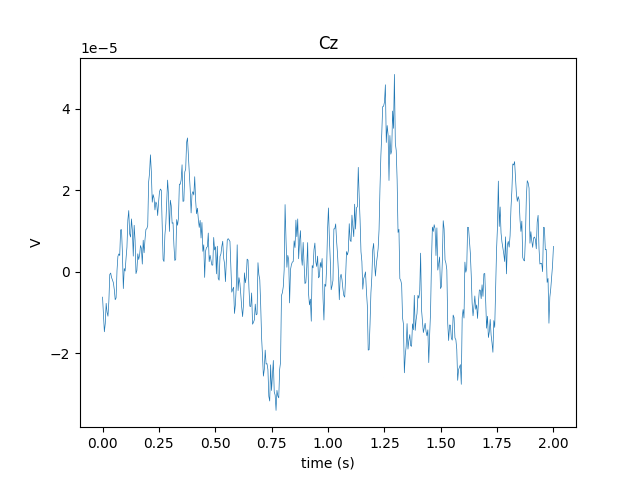

In [6]:
sfreq = int(raw_mne.info['sfreq'])
channels = array(raw_mne.info['ch_names'])
plot_signal(signal, sfreq, channels, 'Cz', n_seconds=2)

<IPython.core.display.Javascript object>


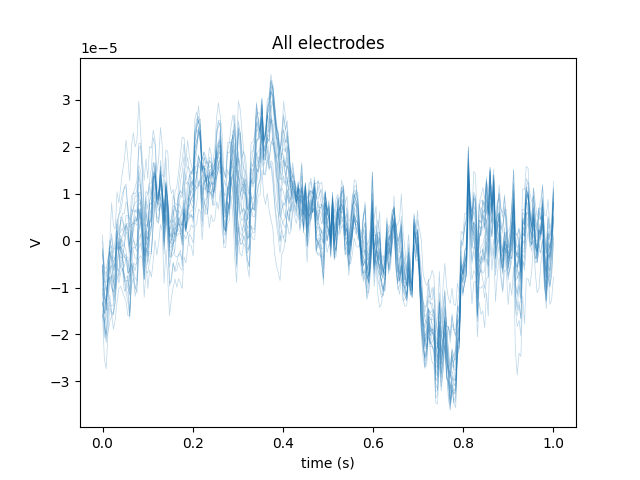

In [7]:
plot_signals(signal, sfreq, n_seconds=1)

# Switching to the space of covariance matrices

Extract 4-second trials from the motor imagery task of dataset IIa. There is 288 trials, 144 for left-hand imagery and 144 for right hand. Only the signal from the 22 EEG electrodes is used, 4s corresponding to 1001 time samples.

In [8]:
X, labels = get_trials_data()
X.shape, labels.shape

((288, 22, 1001), (288,))

Pyriemann allows to estimate the covariance matrices from EEG signal, resulting in 288 matrices of size 22 x 22.

In [9]:
from pyriemann.estimation import Covariances

cov = Covariances().fit_transform(X)
cov.shape

(288, 22, 22)

<IPython.core.display.Javascript object>


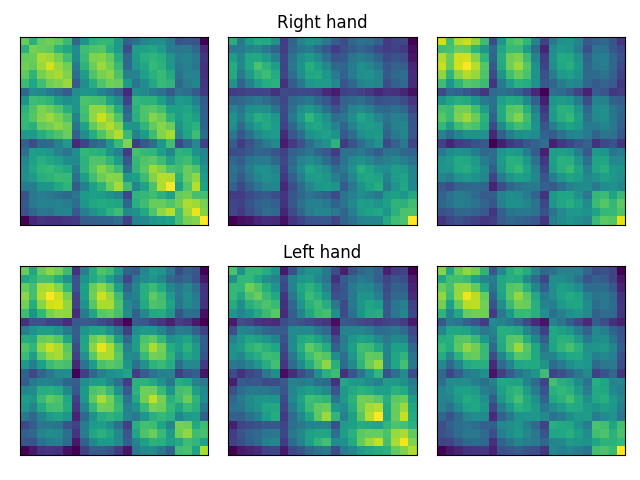

In [10]:
plot_cov(cov, labels, n=3)

All the code to compute the Riemannian mean and distance between covariance matrices is available at hand.

In [11]:
from pyriemann.utils.mean import mean_riemann
mean = mean_riemann(cov)
mean.shape

(22, 22)

In [12]:
from pyriemann.utils.distance import distance_riemann
d = distance_riemann(cov[0], cov[1])
print(d)

3.691205440366134


It is very easy to estimate the mean from some right- and left-hand trials. The distance between each trial and the mean is indicated below each plot.

<IPython.core.display.Javascript object>


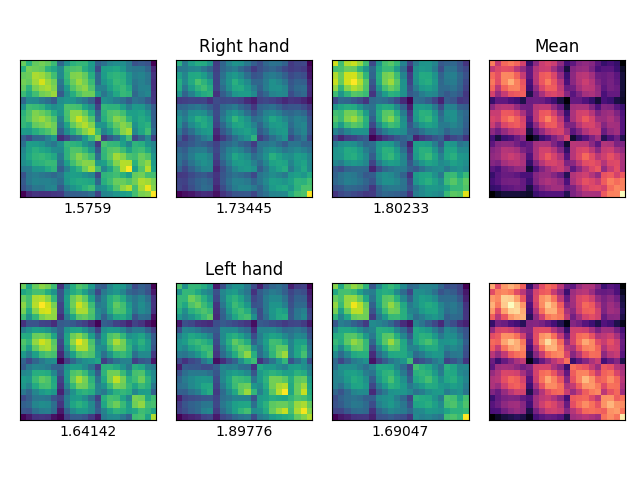

In [13]:
plot_cov_mean(cov, labels, n=3)

It is possible to make a visualization of the matrices in the tangent space, using a PCA to reduce the dimension so the results could be plotted. The class of the matrices are color coded, the mean are indicated by stars.

<IPython.core.display.Javascript object>


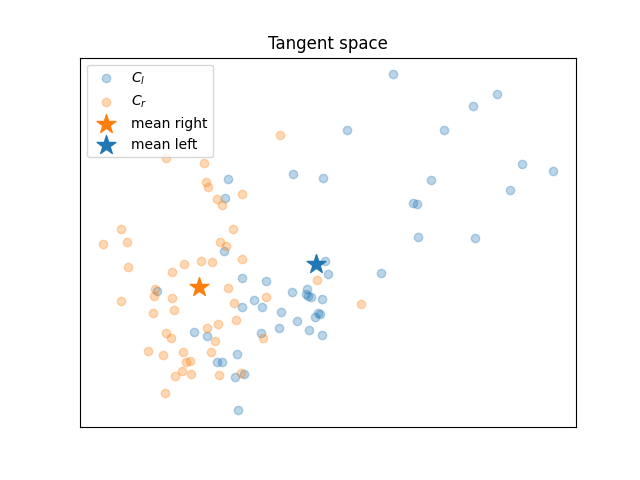

In [14]:
plot_cov_ts(cov, labels, n=50)

# Reimplementing MDM 

We need to split the covariance matrices in a training set (60% of the data) and testing set (40%)

In [15]:
from sklearn.model_selection import train_test_split
cov_tr, cov_te, y_train, y_test = train_test_split(cov, labels, test_size=0.4, shuffle=False)

We could estimate the mean of the matrices from the left and right hand classes.

In [16]:
# train the MDM
right = arange(len(y_train))[y_train == 'right_hand']
left = arange(len(y_train))[y_train == 'left_hand']
classes = ['right_hand', 'left_hand']

mean_r = mean_riemann(cov_tr[right])
mean_l = mean_riemann(cov_tr[left])

To predict the class of the covariance matrices from the testing set, we simply need to compute the distance between each matrix of the testing set and the mean of each class. Each matrix from the testing set is associated to the closest class, with respect to the center of class.

In [17]:
# predict
y_pred = []
for c in cov_te:
    dist = [distance_riemann(c, mean_r), distance_riemann(c, mean_l)]
    y_pred.append(classes[array(dist).argmin()])
print(y_pred[:5])
print(list(y_test[:5]))

['right_hand', 'left_hand', 'left_hand', 'right_hand', 'right_hand']
['right_hand', 'left_hand', 'left_hand', 'left_hand', 'right_hand']


It is possible to compute the accuracy, using scikit-learn function.

In [18]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print ('Accuracy on test set is {:.2f}%'.format(acc*100))

Accuracy on test set is 85.34%


# MDM from pyriemann

The MDM classifier is available in pyriemann, implemented as a scikit-learn estimator, that you could train with `fit()` and use on testing data with `predict()`.

All the above code is thus written in 4 lines.

In [19]:
from pyriemann.classification import MDM

mdm = MDM(n_jobs=-1)
mdm.fit(cov_tr, y_train)
y_pred = mdm.predict(cov_te)
acc = accuracy_score(y_test, y_pred)
print ('Accuracy on test set is {:.2f}%'.format(acc*100))

Accuracy on test set is 85.34%


As it is compliant with scikit-learn, it is possible to use all the possibilities to conduct full evaluation: defining a ML pipeline to convert EEG to covariance and use MDM, using a 5-fold cross-validation to evaluate the classifier, printing the results.

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

X, labels = get_trials_data()
mdm_ppl = make_pipeline(Covariances(), MDM(n_jobs=-1))
res = cross_validate(mdm_ppl, X, labels, scoring='accuracy', cv=5)

print(res["test_score"])
print("5-fold accuracy is {:.2f}% +/-{:.2f}".format(res["test_score"].mean()*100, 
                                                    res["test_score"].std()*100))

[0.72413793 0.87931034 0.86206897 0.85964912 0.87719298]
5-fold accuracy is 84.05% +/-5.87
